In [24]:
import pandas as pd
import sqlalchemy
from matplotlib import pyplot as plt
import datetime
import copy
import numpy as np
from scipy.stats import stats
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [25]:
df = pd.read_csv("/home/memari/jhu_centering/tables/calls_cleaned.csv",parse_dates=['date'])

In [26]:
col = df.columns.tolist()
col.insert(0,'day')
print(col)

['day', 'device_id', 'date', 'incoming_time', 'incoming_freq', 'outgoing_time', 'outgoing_freq', 'missing_time', 'missing_freq']


In [27]:
# find the first day
def find_first_day(device_id, df):
    df_target = df[df['device_id']==device_id]
    return min(df_target['date'])
def halve(df):
    first_day = {device_id:find_first_day(device_id, df) 
                 for device_id in set(df['device_id'].tolist())
                if find_first_day(device_id, df)>=datetime.date(year=2022,month=11,day=11)}
    df = df[df['device_id'].isin(first_day)]
    df['day'] = df.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)
    df_1_14 = df[df['day']<=14]
    df_15_28 = df[(df['day']>14) & (df['day']<=28)]
    return df_1_14,df_15_28
df_1_14,df_15_28 = halve(df)

In [28]:
df_1_14 = df_1_14[col]
df_15_28 = df_15_28[col]

In [29]:
# get the groups form the survey data
df_group = pd.read_csv('/data/meditation/majid/surveys/0.csv',
                       skiprows=[1, 2])[['Study ID', 'Group']]
df_group.columns = ['survey_id', 'group']
df_id = pd.read_csv('/home/memari/jhu_centering/tables/id.csv')

df_group = df_id.merge(df_group, on='survey_id', how='left')
df_group.rename(columns={'device_id1': 'device_id'}, inplace=True)
df_group = df_group.rename(columns={'group_x': 'group'})


In [30]:
df_1_14 = df_1_14.merge(df_group[['device_id', 'group']],
                   on='device_id', how='left')
df_15_28 = df_15_28.merge(df_group[['device_id', 'group']],
                   on='device_id', how='left')

In [31]:
grouped_1_14 = df_1_14 .groupby(['group'])
df_dict = {group: data for group, data in grouped_1_14}
active_control_1_14 = df_dict['Active Control']
experimental_condition_1_14 = df_dict['Experimental Condition']
passive_control_1_14 = df_dict['Passive Control']

In [32]:
grouped_15_28 = df_15_28 .groupby(['group'])
df_dict = {group: data for group, data in grouped_15_28}
active_control_15_28 = df_dict['Active Control']
experimental_condition_15_28 = df_dict['Experimental Condition']
passive_control_15_28 = df_dict['Passive Control']

In [33]:
to_remove = ['day', 'device_id', 'date']
my_list = [item for item in col if item not in to_remove]

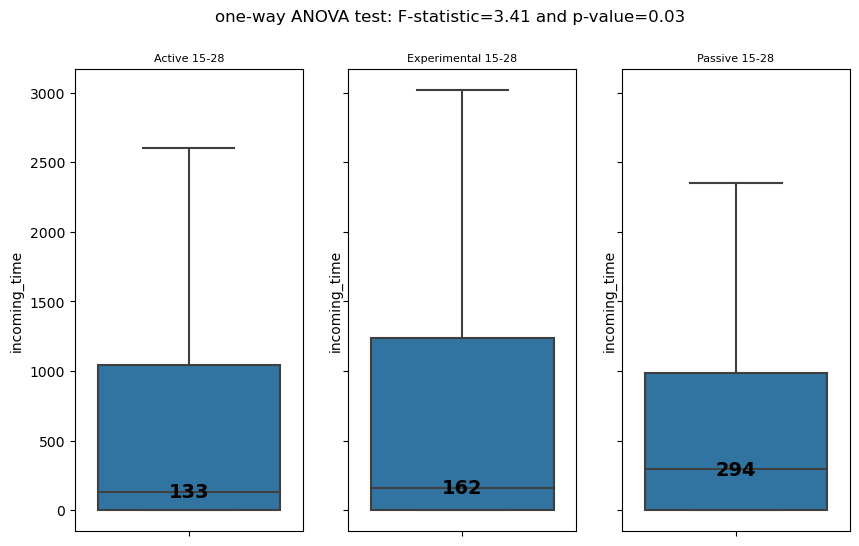

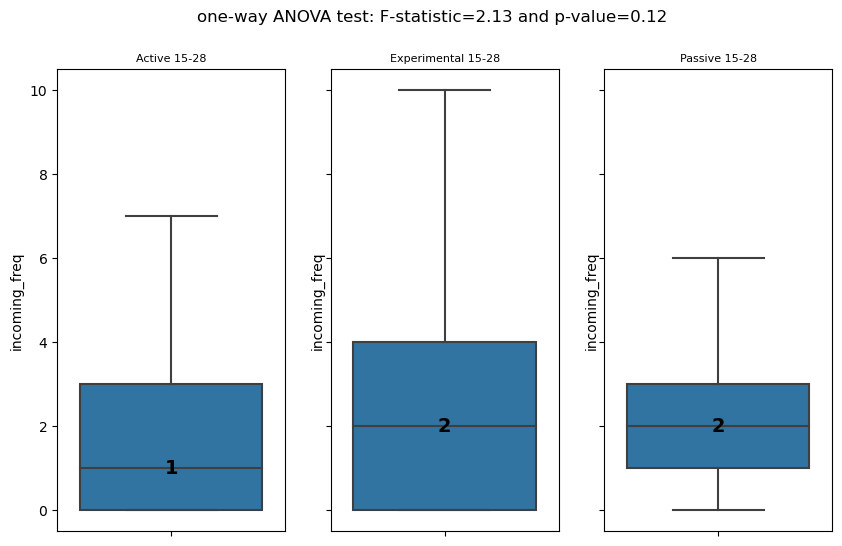

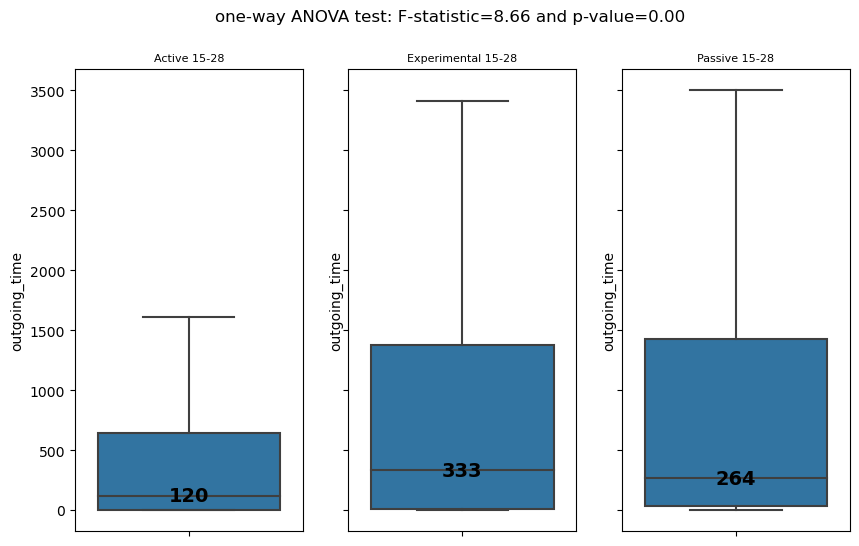

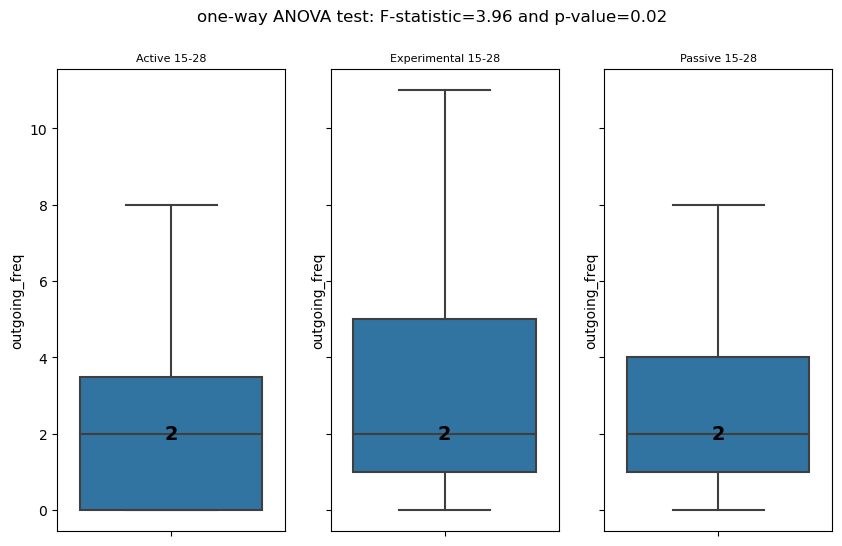

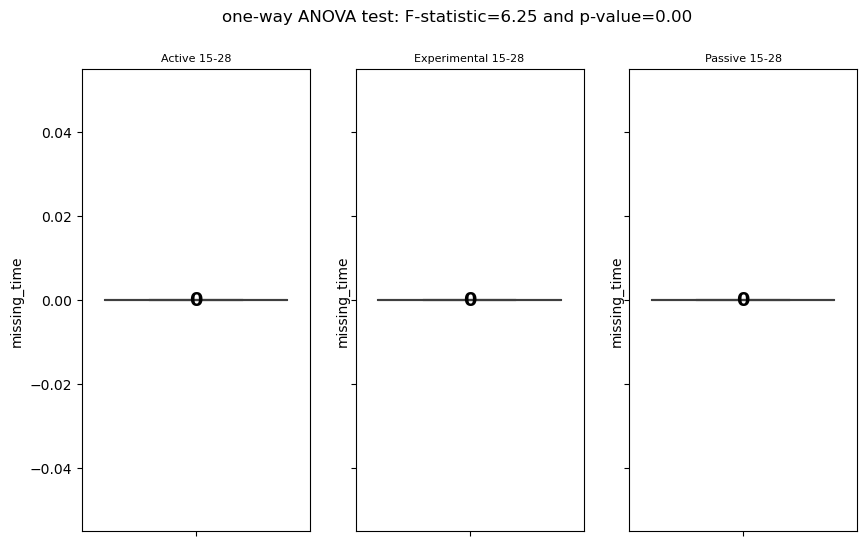

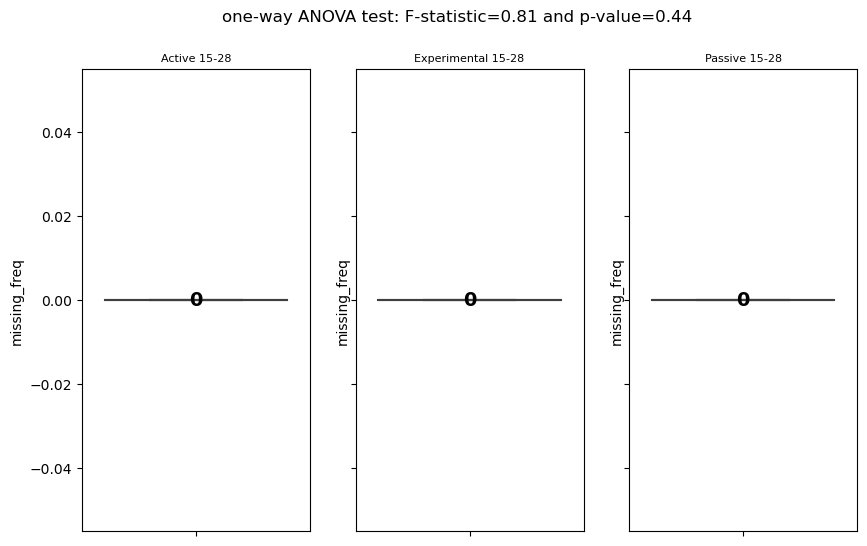

In [34]:
for clm in my_list:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6), sharey=True)

    sns.boxplot(y=active_control_15_28[clm], orient="v", showfliers=False, ax=ax1)

    sns.boxplot(y=experimental_condition_15_28[clm],orient="v", showfliers=False, ax=ax2)

    sns.boxplot(y=passive_control_15_28[clm], orient="v", showfliers=False, ax=ax3)


    ax1.set_title("Active 15-28", fontsize=8)
    m1 = int(active_control_15_28[clm].median())
    ax1.text(0, m1, m1, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    
    ax2.set_title("Experimental 15-28", fontsize=8)
    m2 = int(experimental_condition_15_28[clm].median())
    ax2.text(0, m2, m2, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
   
    ax3.set_title("Passive 15-28", fontsize=8)
    m3 = int(passive_control_15_28[clm].median())
    ax3.text(0, m3, m3, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})

    stat, p = stats.f_oneway(active_control_15_28[clm], experimental_condition_15_28[clm], passive_control_15_28[clm])
    mytext = 'one-way ANOVA test: F-statistic={:.2f} and p-value={:.2f}'.format(
        stat, p)
    plt.suptitle(mytext)
    plt.show()